In [1]:
# 초기 설정(requirements.txt 다운 必)
!pip install -r requirements.txt

In [23]:
# 데이터 처리 & 유틸
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np

# 시각화(글씨체 : 맑은 고딕)
from matplotlib import font_manager, rc
font_location = "C:\\Windows\\Fonts\\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# 머신러닝 모델 & 전처리
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score # 데이터 학습/검증 분할, 하이퍼파라미터 튜닝, 교차검증
from sklearn.preprocessing import StandardScaler, LabelEncoder  # 데이터 표준화 (정규분포에 맞추기)
from sklearn.linear_model import LinearRegression, LogisticRegression  # 선형 회귀, 로지스틱 회귀 모델
from lightgbm import LGBMClassifier  # 트리 기반 부스팅 모델 (성능 좋고 feature importance 해석 가능)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier  # 추가
from sklearn.metrics import classification_report, roc_auc_score

# 모델 평가 지표
from sklearn.metrics import (
    mean_squared_error,  # 회귀 성능평가 (MSE)
    accuracy_score,      # 정확도
    classification_report, # Precision, Recall, F1-score 등 종합 리포트
    r2_score,            # 회귀 모델 설명력 (R²)
    confusion_matrix,    # 혼동행렬 (분류 결과 시각화용)
    roc_curve,           # ROC 커브 (분류 임계값 시각화)
    auc,                 # AUC 값 (ROC 성능 요약)
    precision_recall_curve, # Precision-Recall 곡선
    precision_score, recall_score, f1_score # 개별 지표
)

# 모델 해석
import shap  # 모델 해석 라이브러리 (LightGBM 등에서 feature 영향 시각화 가능)

In [3]:
file_path = "data/food_data_4.csv"
df = pd.read_csv(file_path, low_memory=False)

print("원본 데이터 크기 : ", df.shape)
print("컬럼 샘플 : ", df.columns[:10].tolist())

원본 데이터 크기 :  (167337, 193)
컬럼 샘플 :  ['번호', '식품코드', '식품명', '데이터구분코드', '데이터구분명', '품목대표/상용제품_코드', '품목대표/상용제품', '식품기원코드', '식품기원명', '식품대분류코드']


In [4]:
sugar_cols = ["포도당(g)", "자당(g)", "과당(g)", "유당(g)", "맥아당(g)"]

# 혈당 스파이크 완화 & 인슐린 민감도와 관련된 컬럼
nutrient_cols = ["식이섬유(g)", "단백질(g)", "지방(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]

# 가장 기본적인 총량 지표로 sugar_cols와 비교 분석을 위한 정의
base_cols = ["에너지(kcal)", "탄수화물(g)", "당류(g)"]

selected_cols = sugar_cols + nutrient_cols + base_cols
df_sub = df[selected_cols].copy()

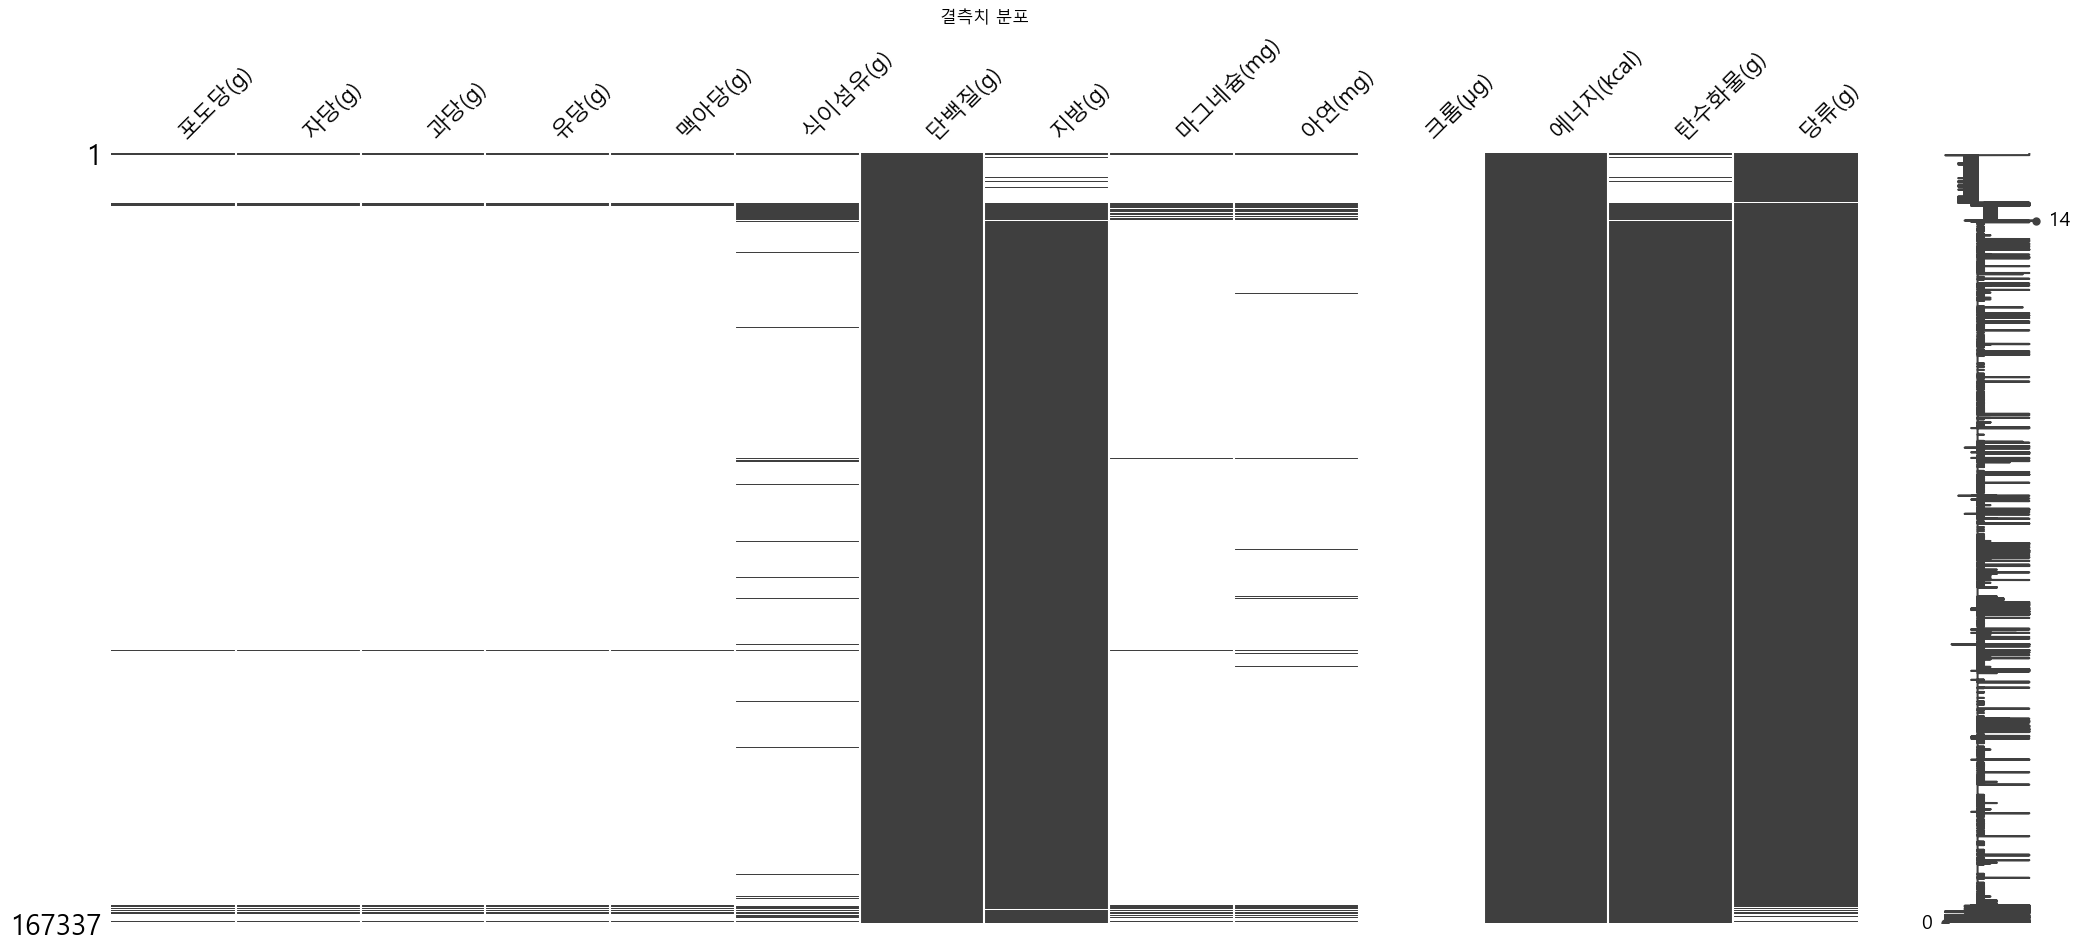

In [5]:
# 결측치 시각화
msno.matrix(df_sub)
plt.title("결측치 분포")
plt.show()

In [6]:
# 데이터 전처리
for c in df_sub.columns:
    df_sub[c] = pd.to_numeric(df_sub[c], errors="coerce").fillna(0)

df_sub["총당류"] = df_sub[sugar_cols].sum(axis=1)
df_sub["주요당류"] = df_sub[["포도당(g)", "자당(g)", "맥아당(g)"]].sum(axis=1)
df_sub["과당_only"] = df_sub["과당(g)"]
df_sub["유당_only"] = df_sub["유당(g)"]

print(df_sub.head())

   포도당(g)  자당(g)  과당(g)  유당(g)  맥아당(g)  식이섬유(g)  단백질(g)  지방(g)  마그네슘(mg)  \
0     0.0    0.0   0.16    0.0     0.0      0.7    6.70   5.16      5.06   
1     0.0    0.0   0.17    0.0     0.0      1.3    3.17   2.28      5.80   
2     0.0    0.0   0.00    0.0     0.0      1.2    1.45   0.24      5.45   
3     0.0    0.0   0.00    0.0     0.0      1.5    3.44   0.57      6.77   
4     0.0    0.0   0.00    0.0     0.0      1.4    4.84   4.55     12.33   

   아연(mg)  크롬(μg)  에너지(kcal)  탄수화물(g)  당류(g)   총당류  주요당류  과당_only  유당_only  
0    0.39     0.0      137.0    15.94   0.16  0.16   0.0     0.16      0.0  
1    0.71     0.0       75.0    10.38   0.17  0.17   0.0     0.17      0.0  
2    0.36     0.0       52.0    10.93   0.00  0.00   0.0     0.00      0.0  
3    0.82     0.0      166.0    36.77   0.00  0.00   0.0     0.00      0.0  
4    0.52     0.0      140.0    19.98   0.00  0.00   0.0     0.00      0.0  


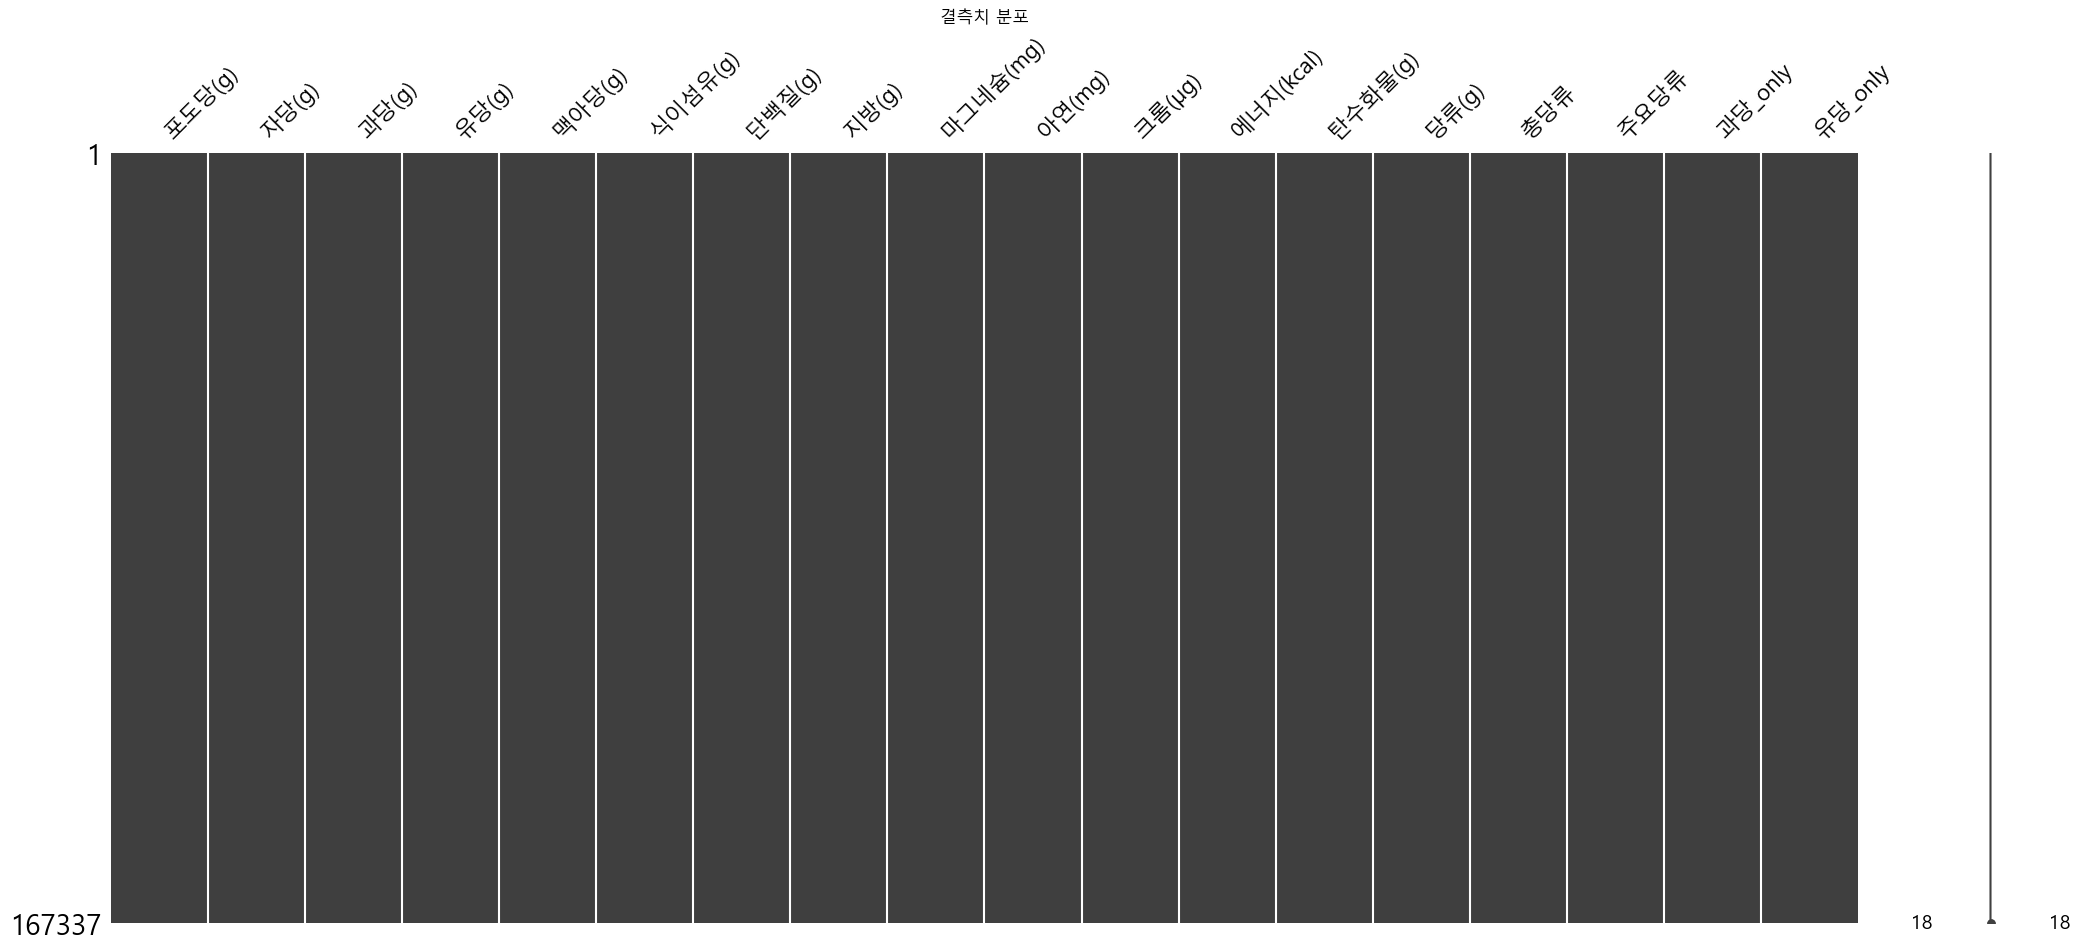

In [7]:
# 결측치 시각화
msno.matrix(df_sub)
plt.title("결측치 분포")
plt.show()

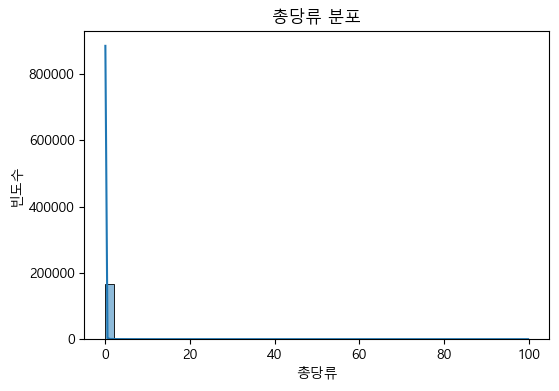

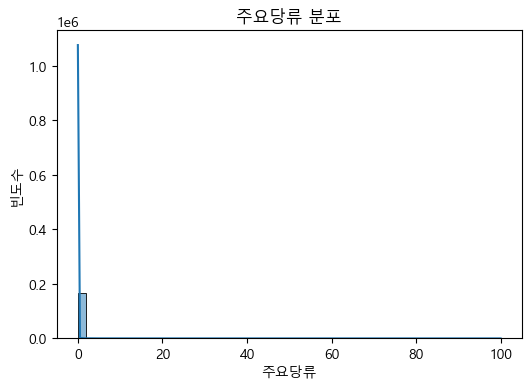

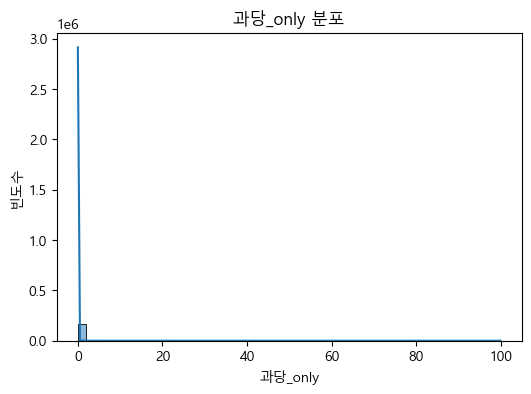

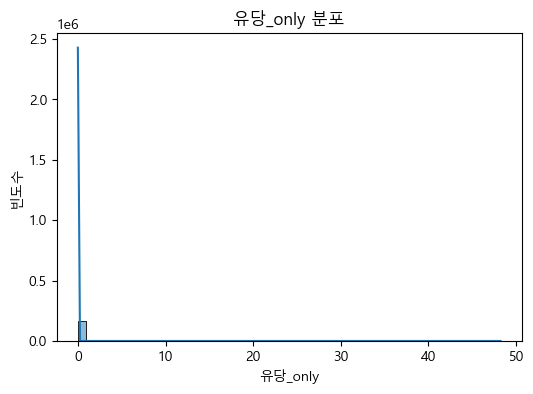

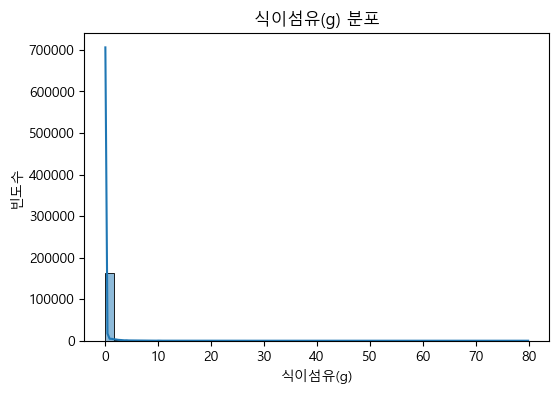

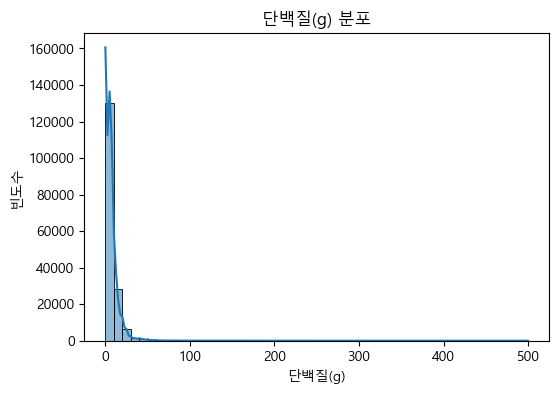

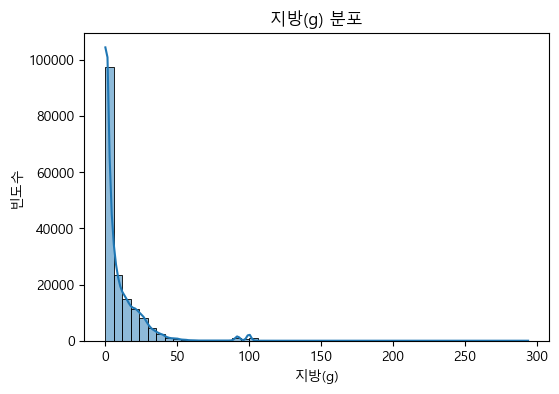

In [8]:
# 주요 변수 분포 확인
features = ["총당류", "주요당류", "과당_only", "유당_only",
            "식이섬유(g)", "단백질(g)", "지방(g)"]

for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(df_sub[col], bins=50, kde=True)
    plt.title(f"{col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도수")
    plt.show()

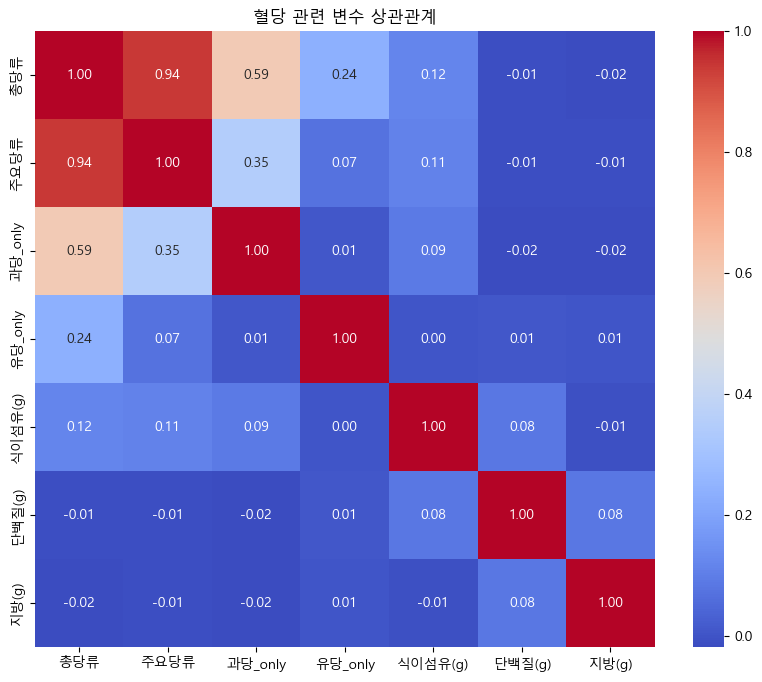

In [9]:
# 상관관계 히트맵
plt.figure(figsize=(10,8))
corr = df_sub[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("혈당 관련 변수 상관관계")
plt.show()

In [10]:
# 종속변수: 총당류
y = df_sub["총당류"]

# 독립변수: 기존 영양소
features = ["에너지(kcal)", "탄수화물(g)", "식이섬유(g)",
            "단백질(g)", "지방(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]
X = df_sub[features]

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀모델 학습
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 예측 & 평가
y_pred = linreg.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# 계수 확인
coef_dict = dict(zip(features, linreg.coef_))
print("회귀계수:", coef_dict)

R²: 0.026355460850558732
MSE: 3.0523231262184805
회귀계수: {'에너지(kcal)': np.float64(0.00014274861241377957), '탄수화물(g)': np.float64(0.001796341942020195), '식이섬유(g)': np.float64(0.07696492399122423), '단백질(g)': np.float64(-0.006187562745942987), '지방(g)': np.float64(-0.0027101351378998177), '마그네슘(mg)': np.float64(0.015489317068313586), '아연(mg)': np.float64(0.0013429485953649271), '크롬(μg)': np.float64(-0.005669533110951579)}


## ※ 총당류는 탄수화물·식이섬유·칼로리와 미미하게 연관이 있음, 다른 영양소로는 거의 설명이 불가

In [11]:
# 독립변수 (기존 영양소들)
features = ["에너지(kcal)", "탄수화물(g)", "식이섬유(g)", 
            "단백질(g)", "지방(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]
X = df_sub[features]

# 기준점 리스트
thresholds = [10, 15, 20]

results = {}

for th in thresholds:
    print("="*40)
    print(f"총당류 기준: {th} g 이상 → 고당류 라벨")
    
    # 1. 타깃 정의
    y = (df_sub["총당류"] >= th).astype(int)
    
    # 2. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. 로지스틱 회귀 (불균형 보정: class_weight="balanced")
    logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
    logreg.fit(X_train, y_train)
    
    # 4. 평가
    y_pred = logreg.predict(X_test)
    auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
    
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", auc_score)
    
    coef_dict = dict(zip(features, logreg.coef_[0]))
    print("회귀계수:", coef_dict)
    
    results[th] = {"AUC": auc_score, "coef": coef_dict}


총당류 기준: 10 g 이상 → 고당류 라벨
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     33389
           1       0.03      0.91      0.06        79

    accuracy                           0.94     33468
   macro avg       0.52      0.92      0.51     33468
weighted avg       1.00      0.94      0.96     33468

ROC AUC: 0.9540292395244245
회귀계수: {'에너지(kcal)': np.float64(0.0014340974179806642), '탄수화물(g)': np.float64(0.017085747318436866), '식이섬유(g)': np.float64(0.6185090787099664), '단백질(g)': np.float64(-0.4005856149760301), '지방(g)': np.float64(-0.02849996238264443), '마그네슘(mg)': np.float64(0.21154891009358132), '아연(mg)': np.float64(0.06725165819166763), '크롬(μg)': np.float64(-1.7419149638199793)}
총당류 기준: 15 g 이상 → 고당류 라벨
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     33416
           1       0.02      0.96      0.04        52

    accuracy                           0.93     33468
   macro avg     

## ○ 로지스틱 회귀 분석 결과
  - 분류 성능
    - 공통적으로: Accuracy는 매우 높지만, 이는 대부분 샘플이 “저당류(0)”라서 생기는 현상.
    - 고당류 클래스(1)**는 적지만, class_weight="balanced" 덕분에 **Recall(재현율)**이 높음 (거의 0.9 이상).
    - Precision(정밀도)**는 매우 낮음 (0.02~0.03) → 예측한 1 중에 실제로 1인 경우는 거의 없음.
    - ROC AUC는 높음 (0.95~0.98) → 확률 스코어 자체는 분리력이 꽤 좋다.
※ 해석: 모델이 고당류를 잘 찾아내긴 하지만, 불균형 때문에 “고당류라고 찍으면 대부분 틀린다.

  - 컷오프별 차이
    - 10g 컷
      - 식이섬유 영향이 제일 크다 (+0.61).
      - 비교적 “과일·곡물류 vs 고기류” 구분에 가까움.
    - 15g 컷
      - 탄수화물 계수 +0.022, 에너지 계수도 커짐.
      - 즉, 고당류 판별에 칼로리·탄수화물의 영향력이 뚜렷해짐.
    - 20g 컷
      - 탄수화물 영향력 최댓값 (+0.031).
      - 식이섬유 영향은 줄었지만, 단백질(-0.27), 지방(-0.08) 영향은 강화.

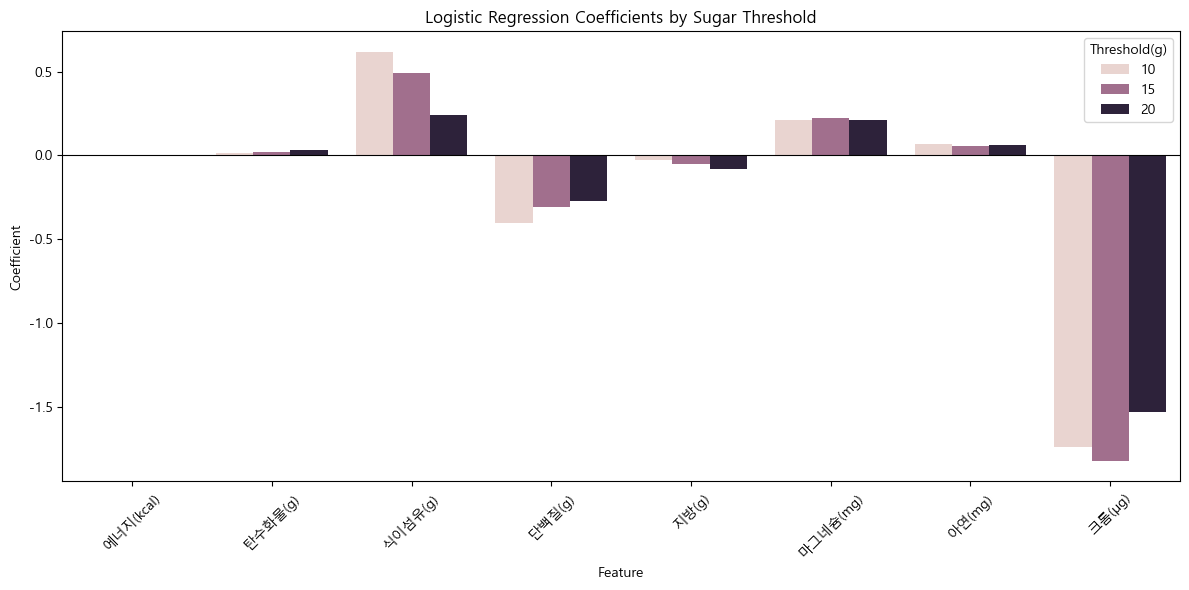

In [12]:
# DataFrame으로 변환
coef_df = pd.DataFrame({th: results[th]["coef"] for th in results}).T
coef_df.index.name = "Threshold(g)"
coef_df = coef_df.reset_index()

# 시각화
plt.figure(figsize=(12,6))
coef_df_melted = coef_df.melt(id_vars="Threshold(g)", var_name="Feature", value_name="Coefficient")

sns.barplot(data=coef_df_melted, x="Feature", y="Coefficient", hue="Threshold(g)")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Logistic Regression Coefficients by Sugar Threshold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ○ 세 모델 특징
1. LightGBM: 속도가 빠르고 대용량 데이터에 유리. 기본적으로 범주형 처리 약함 → one-hot 필요.
2. XGBoost: 전통적인 GBDT 구현. 안정적이고 튜닝 노하우 많음. 속도는 LightGBM보다 조금 느림.
3. CatBoost: 범주형 변수 자동 처리 강점. 파라미터 튜닝 덜 해도 잘 나옴.

# 1) LightGBM

총당류 기준: 15g 이상 → 고당류 라벨
[LightGBM] [Info] Number of positive: 209, number of negative: 133660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 133869, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33416
           1       0.41      0.79      0.54        52

    accuracy                           1.00     33468
   macro avg       0.71      0.89      0.77     33468
weighted avg       1.00      1.00      1.00     33468

ROC AUC: 0.9956981685420158
총당류 기준: 20g 이상 → 고당류 라벨
[LightGBM] [Info] Number of positive: 151, number of negative: 133718
[LightGBM] [Info] Auto-choosing col-

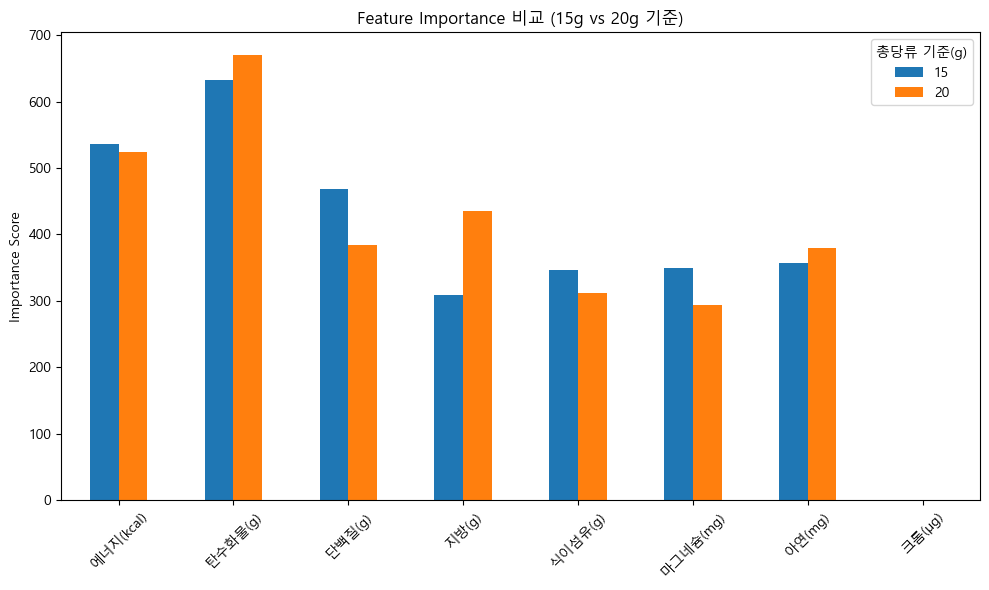

In [13]:
features = ["에너지(kcal)", "탄수화물(g)", "단백질(g)", "지방(g)", 
            "식이섬유(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]

thresholds = [15, 20]
importances_all = {}

for th in thresholds:
    print("="*40)
    print(f"총당류 기준: {th}g 이상 → 고당류 라벨")
    
    # 라벨 정의
    df_sub["고당류"] = (df_sub["총당류"] >= th).astype(int)
    X = df_sub[features]
    y = df_sub["고당류"]
    
    # 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 모델 학습
    lgbm = LGBMClassifier(random_state=42, class_weight="balanced")
    lgbm.fit(X_train, y_train)
    
    # 평가
    y_pred = lgbm.predict(X_test)
    y_proba = lgbm.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    # Feature Importance 저장
    importances_all[th] = pd.Series(lgbm.feature_importances_, index=features)

# ---- 시각화 ----
importances_df = pd.DataFrame(importances_all)
importances_df.plot(kind="bar", figsize=(10,6))
plt.title("Feature Importance 비교 (15g vs 20g 기준)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.legend(title="총당류 기준(g)")
plt.tight_layout()
plt.show()

# 2) XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33430
           1       0.55      0.87      0.67        38

    accuracy                           1.00     33468
   macro avg       0.77      0.93      0.84     33468
weighted avg       1.00      1.00      1.00     33468

ROC AUC: 0.9987251444495174


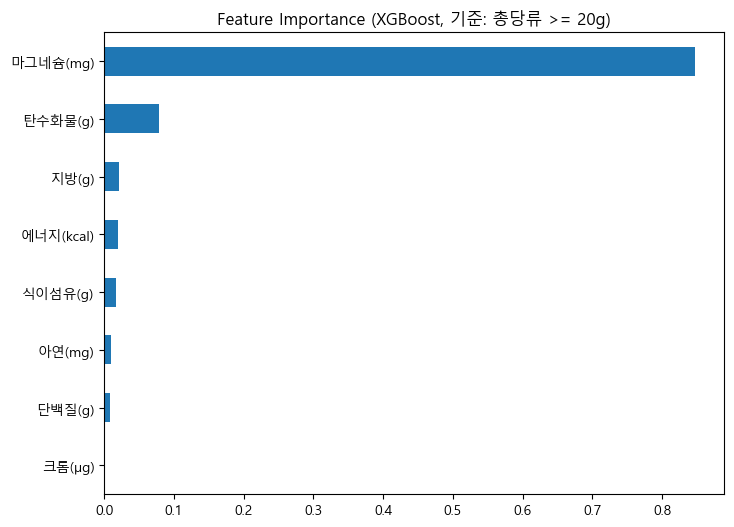

In [15]:
# 1. 라벨 정의 (WHO 기준: 총당류 >= 20g → 고당류)
df_sub["고당류"] = (df_sub["총당류"] >= 20).astype(int)

# 2. 피처 선택
features = ["에너지(kcal)", "탄수화물(g)", "단백질(g)", "지방(g)", 
            "식이섬유(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]
X = df_sub[features]
y = df_sub["고당류"]

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 클래스 불균형 비율 계산
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# 5. 모델 학습
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

# 6. 평가
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Feature Importance
importances = pd.Series(xgb.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (XGBoost, 기준: 총당류 >= 20g)")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33430
           1       0.33      0.95      0.49        38

    accuracy                           1.00     33468
   macro avg       0.67      0.97      0.74     33468
weighted avg       1.00      1.00      1.00     33468

ROC AUC: 0.9991640033376892


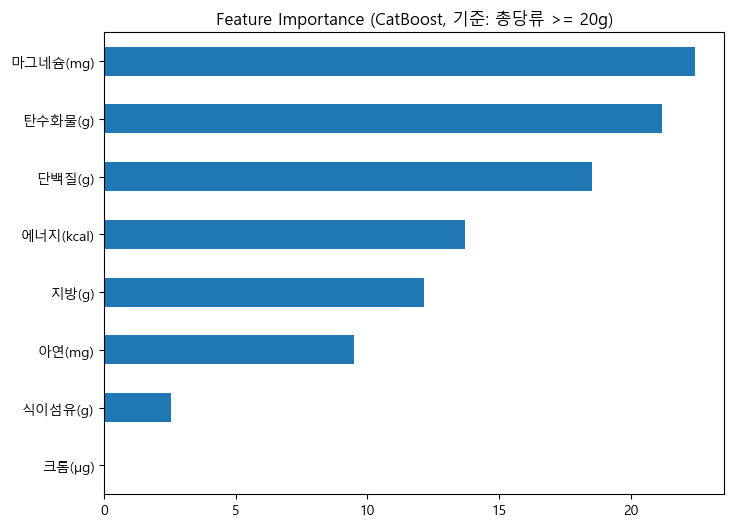

In [16]:
# 1. 라벨 정의 (WHO 기준: 총당류 >= 20g → 고당류)
df_sub["고당류"] = (df_sub["총당류"] >= 20).astype(int)

# 2. 피처 선택
features = ["에너지(kcal)", "탄수화물(g)", "단백질(g)", "지방(g)", 
            "식이섬유(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]
X = df_sub[features]
y = df_sub["고당류"]

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 클래스 불균형 보정 (CatBoost는 class_weights 인자 사용)
neg, pos = y_train.value_counts()
class_weights = [1, neg/pos]

# 5. 모델 학습
cat = CatBoostClassifier(
    random_state=42,
    class_weights=class_weights,
    silent=True
)
cat.fit(X_train, y_train)

# 6. 평가
y_pred = cat.predict(X_test)
y_proba = cat.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Feature Importance
importances = pd.Series(cat.get_feature_importance(), index=features)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (CatBoost, 기준: 총당류 >= 20g)")
plt.show()

[LightGBM] [Info] Number of positive: 151, number of negative: 133718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 133869, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,모델,Precision (고당류),Recall (고당류),F1-score (고당류),ROC AUC
0,LightGBM,0.47,0.89,0.62,0.9982
1,XGBoost,0.55,0.87,0.67,0.9987
2,CatBoost,0.33,0.95,0.49,0.9992


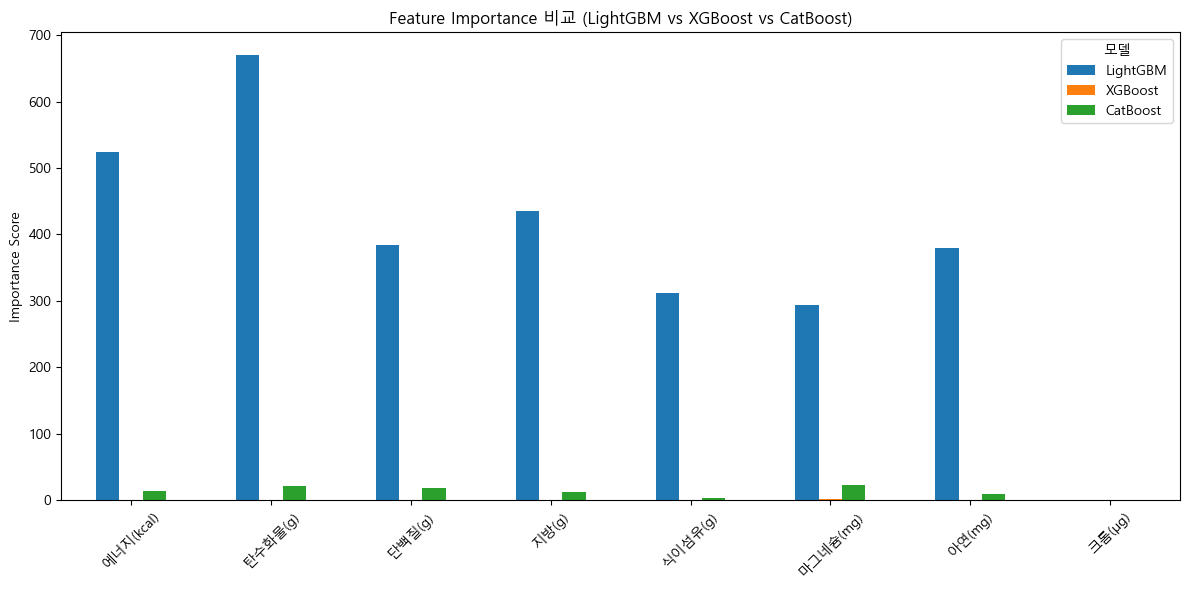

In [17]:
# 1. 라벨 정의 (WHO 기준: 총당류 >= 20g → 고당류)
df_sub["고당류"] = (df_sub["총당류"] >= 20).astype(int)

# 2. 피처 선택
features = ["에너지(kcal)", "탄수화물(g)", "단백질(g)", "지방(g)", 
            "식이섬유(g)", "마그네슘(mg)", "아연(mg)", "크롬(μg)"]
X = df_sub[features]
y = df_sub["고당류"]

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 클래스 불균형 보정
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
neg, pos = y_train.value_counts()
class_weights = [1, neg/pos]

# 5. 모델 정의
models = {
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(random_state=42, class_weights=class_weights, silent=True)
}

# 6. 학습 및 평가
importances_all = {}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "모델": name,
        "Precision (고당류)": round(report["1"]["precision"], 2),
        "Recall (고당류)": round(report["1"]["recall"], 2),
        "F1-score (고당류)": round(report["1"]["f1-score"], 2),
        "ROC AUC": round(roc_auc, 4)
    })
    
    # Feature Importance
    if name == "CatBoost":
        importances_all[name] = pd.Series(model.get_feature_importance(), index=features)
    else:
        importances_all[name] = pd.Series(model.feature_importances_, index=features)

# 7. 결과 표
results_df = pd.DataFrame(results)
display(results_df)

# 8. Feature Importance 비교 시각화
importances_df = pd.DataFrame(importances_all)
importances_df.plot(kind="bar", figsize=(12,6))
plt.title("Feature Importance 비교 (LightGBM vs XGBoost vs CatBoost)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.legend(title="모델")
plt.tight_layout()
plt.show()

In [39]:
# 1. 사용할 피처 (GIS 계산에 쓰였던 영양소)
features = [
    '에너지(kcal)','탄수화물(g)','당류(g)','식이섬유(g)','단백질(g)','지방(g)',
    '포화지방산(g)','트랜스지방산(g)','포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

# 2. 데이터 준비 (NaN → 0, 숫자형 변환)
df_sub = df.copy()
for c in features:
    if c in df_sub.columns:
        df_sub[c] = pd.to_numeric(df_sub[c], errors='coerce').fillna(0)

# 3. 목표 변수 (총당류)
y = df_sub["당류(g)"]

# 4. 독립 변수
X = df_sub[features].drop(columns=["당류(g)"], errors="ignore")

# 5. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 선형 회귀 학습
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 7. 결과 해석
coef_dict = dict(zip(X.columns, linreg.coef_))

print("회귀계수 (데이터 기반 가중치):")
for k,v in coef_dict.items():
    print(f"{k}: {v:.4f}")

print("\nR² 설명력:", linreg.score(X_test, y_test))

회귀계수 (데이터 기반 가중치):
에너지(kcal): 0.0181
탄수화물(g): 0.2779
식이섬유(g): -0.4164
단백질(g): -0.3235
지방(g): -0.2503
포화지방산(g): 0.5811
트랜스지방산(g): -0.3413
포도당(g): 0.6158
자당(g): 0.4459
과당(g): 0.5748
유당(g): 0.5097
칼륨(mg): -0.0032
마그네슘(mg): -0.0046
아연(mg): 0.0088
크롬(μg): -0.1463
비타민_D(μg): 0.0028
비타민_B1(mg): 0.0148
비타민_B2(mg): -0.0180
비타민_B6(mg): 0.0295
비타민_B12(μg): -0.0479
니아신(mg): 0.0049
비타민_C(mg): 0.0165
비타민_E(mg): -0.0848

R² 설명력: 0.402535284280632


In [19]:
# --- Min-Max 정규화 함수 ---
def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

# --- 1. 회귀계수 기반 GIS 점수 ---
GIS_raw = (
    coef_dict.get("에너지(kcal)",0)*df_sub["에너지(kcal)"] +
    coef_dict.get("탄수화물(g)",0)*df_sub["탄수화물(g)"] +
    coef_dict.get("식이섬유(g)",0)*df_sub["식이섬유(g)"] +
    coef_dict.get("단백질(g)",0)*df_sub["단백질(g)"] +
    coef_dict.get("지방(g)",0)*df_sub["지방(g)"] +
    coef_dict.get("포화지방산(g)",0)*df_sub["포화지방산(g)"] +
    coef_dict.get("트랜스지방산(g)",0)*df_sub["트랜스지방산(g)"] +
    coef_dict.get("포도당(g)",0)*df_sub["포도당(g)"] +
    coef_dict.get("자당(g)",0)*df_sub["자당(g)"] +
    coef_dict.get("과당(g)",0)*df_sub["과당(g)"] +
    coef_dict.get("유당(g)",0)*df_sub["유당(g)"] +
    coef_dict.get("칼륨(mg)",0)*df_sub["칼륨(mg)"] +
    coef_dict.get("마그네슘(mg)",0)*df_sub["마그네슘(mg)"] +
    coef_dict.get("아연(mg)",0)*df_sub["아연(mg)"] +
    coef_dict.get("크롬(μg)",0)*df_sub["크롬(μg)"] +
    coef_dict.get("비타민_D(μg)",0)*df_sub["비타민_D(μg)"] +
    coef_dict.get("비타민_B1(mg)",0)*df_sub["비타민_B1(mg)"] +
    coef_dict.get("비타민_B2(mg)",0)*df_sub["비타민_B2(mg)"] +
    coef_dict.get("비타민_B6(mg)",0)*df_sub["비타민_B6(mg)"] +
    coef_dict.get("비타민_B12(μg)",0)*df_sub["비타민_B12(μg)"] +
    coef_dict.get("니아신(mg)",0)*df_sub["니아신(mg)"] +
    coef_dict.get("비타민_C(mg)",0)*df_sub["비타민_C(mg)"] +
    coef_dict.get("비타민_E(mg)",0)*df_sub["비타민_E(mg)"]
)

# --- 2. 정규화 (0~100 스케일) ---
df_sub["GIS_dynamic"] = (minmax(GIS_raw) * 100).round(2)

# --- 3. 퍼센타일 기준 등급화 ---
p20, p80 = np.percentile(df_sub["GIS_dynamic"], [20, 80])

def label(v):
    if v <= p20: return "RECOMMENDED"
    if v >= p80: return "WORST"
    return "OK"

df_sub["GIS_label"] = df_sub["GIS_dynamic"].apply(label)

# --- 4. 결과 미리보기 ---
df_out = df_sub[["식품명","GIS_dynamic","GIS_label"]].head(10)
display(df_out)

print(f"p20={p20:.1f}, p80={p80:.1f}")

,식품명,GIS_dynamic,GIS_label
0,국밥_돼지머리,38.05,OK
1,국밥_순대국밥,37.79,OK
2,국밥_콩나물,37.81,OK
3,기장밥,39.74,OK
4,김밥,38.30,OK
5,김밥_김치,38.26,OK
6,김밥_날치알,38.99,OK
7,김밥_돈가스,39.19,OK
8,김밥_소고기,38.72,OK
9,김밥_참치,38.17,OK


p20=37.4, p80=41.6


## ○ 세 가지 버전 개요
1. 기존 GIS (수동 가중치 공식)
    - 당류, 포화지방, 식이섬유, 단백질, 비타민 등 가중치 직접 부여해서 점수화.
    - 영양학적 직관”에 기반한 방식.

2. 회귀 기반 GIS (데이터 학습된 가중치 공식)
    - 선형회귀 계수를 그대로 가중치로 적용.
    - “데이터가 말해주는 연관성”을 반영.

3. GI/GL 혼합 GIS (실험 기반 + 데이터 기반 융합)
    - GI/GL 개념을 반영 (탄수화물 양 × 혈당 영향)
    - 나머지 성분은 회귀 계수 or 직관 가중치로 조정.
    - “실험 데이터 + 통계 모델” 융합형.

## GI / GL 정의와 공식 (캡처본)

![GI/GL 공식 캡처](GI_GL_공식.jpg)

- **주요 근거:**  
  - Harvard T.H. Chan School of Public Health: [Carbohydrates and the Glycemic Index](https://www.hsph.harvard.edu/nutritionsource/carbohydrates/carbohydrates-and-blood-sugar/)  
  - Atkinson et al., *International Tables of Glycemic Index and Glycemic Load Values* (2008)  

- **주요 근거:**  
  - Harvard T.H. Chan School of Public Health: [Glycemic Load](https://www.hsph.harvard.edu/nutritionsource/carbohydrates/carbohydrates-and-blood-sugar/#glycemic_index_and_glycemic_load)  
  - Foster-Powell et al., *International Table of Glycemic Index and Glycemic Load Values: 2002* (Am J Clin Nutr, 2002)  

In [20]:
# 1. 공통 전처리
features = [
    '에너지(kcal)','탄수화물(g)','당류(g)','식이섬유(g)','단백질(g)','지방(g)',
    '포화지방산(g)','트랜스지방산(g)','포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

df_sub = df.copy()
for c in features:
    if c in df_sub.columns:
        df_sub[c] = pd.to_numeric(df_sub[c], errors="coerce").fillna(0)

# Min-Max 정규화
def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

# 2. 버전별 GIS 계산

# (1) 기존 GIS 방식
GIS_raw_v1 = (
    0.3*df_sub['에너지(kcal)'] +
    0.4*df_sub['탄수화물(g)'] +
    0.4*df_sub['당류(g)'] -
    0.25*df_sub['식이섬유(g)'] -
    0.25*df_sub['단백질(g)'] +
    0.5*df_sub['포화지방산(g)'] +
    0.2*df_sub['트랜스지방산(g)']
)
df_sub["GIS_v1"] = (minmax(GIS_raw_v1)*100).round(2)

# (2) 회귀 기반 GIS (coef_dict는 미리 학습된 회귀계수 딕셔너리)
GIS_raw_v2 = sum([
    coef_dict.get(c,0)*df_sub[c] for c in features if c in coef_dict
])
df_sub["GIS_v2"] = (minmax(GIS_raw_v2)*100).round(2)

# (3) GI/GL 혼합 GIS
# GI 테이블이 있다면 merge해서 반영 가능. 여기선 단순히 탄수화물×0.5 + 당류×0.5 예시.
GIS_raw_v3 = (
    0.5*df_sub['탄수화물(g)'] +
    0.5*df_sub['당류(g)'] -
    0.3*df_sub['식이섬유(g)'] -
    0.2*df_sub['단백질(g)'] +
    0.4*df_sub['포화지방산(g)']
)
df_sub["GIS_v3"] = (minmax(GIS_raw_v3)*100).round(2)

# 3. 등급화 (공통)
def labelize(series):
    p20, p80 = np.percentile(series, [20, 80])
    return series.apply(lambda v: "RECOMMENDED" if v<=p20 else ("WORST" if v>=p80 else "OK"))

df_sub["GIS_v1_label"] = labelize(df_sub["GIS_v1"])
df_sub["GIS_v2_label"] = labelize(df_sub["GIS_v2"])
df_sub["GIS_v3_label"] = labelize(df_sub["GIS_v3"])

# 4. 결과 확인
df_out = df_sub[["식품명","GIS_v1","GIS_v1_label","GIS_v2","GIS_v2_label","GIS_v3","GIS_v3_label"]].head(10)
display(df_out)

,식품명,GIS_v1,GIS_v1_label,GIS_v2,GIS_v2_label,GIS_v3,GIS_v3_label
0,국밥_돼지머리,21.24,OK,38.05,OK,11.24,OK
1,국밥_순대국밥,18.74,RECOMMENDED,37.79,OK,11.00,OK
2,국밥_콩나물,17.89,RECOMMENDED,37.81,OK,11.01,OK
3,기장밥,23.33,OK,39.74,OK,12.31,OK
4,김밥,21.56,OK,38.30,OK,11.45,OK
5,김밥_김치,21.16,OK,38.26,OK,11.42,OK
6,김밥_날치알,23.38,OK,38.99,OK,11.93,OK
7,김밥_돈가스,24.45,OK,39.19,OK,12.09,OK
8,김밥_소고기,23.27,OK,38.72,OK,11.74,OK
9,김밥_참치,22.81,OK,38.17,OK,11.45,OK


## ○ 분석
1. GIS_v1 (수동 가중치)
    - 영양학적 직관 기반. “학계 일반 지식”을 반영하지만, 네 데이터셋에 맞춰진 건 아님. → 설명은 쉽지만 개인 맞춤엔 약해.

2. GIS_v2 (회귀 기반)
    - 네 데이터셋에서 직접 학습한 가중치. “데이터 안에서의 상관관계”를 잘 반영. → 하지만 당류 분포가 불균형(고당류 적음)이라 과적합·왜곡 위험 있음.

3. GIS_v3 (GI/GL 혼합)
    - 혈당 실험에서 쓰는 지표(GI=혈당지수, GL=혈당부하)를 흉내 내면서, 추가 영양소 보정을 할 수 있는 유연한 방식.
    - 따라서 개인차 반영(GI는 음식·조리법·개인체질 따라 변함)에도 적응할 수 있는 장점.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5462
[LightGBM] [Info] Number of data points in the train set: 133869, number of used features: 24
[LightGBM] [Info] Start training from score -0.514748
[LightGBM] [Info] Start training from score -1.602099
[LightGBM] [Info] Start training from score -1.605070
Accuracy: 0.9937851081630213

Classification Report:
               precision    recall  f1-score   support

          OK       0.99      1.00      0.99     20002
 RECOMMENDED       0.99      0.99      0.99      6743
       WORST       0.99      0.99      0.99      6723

    accuracy                           0.99     33468
   macro avg       0.99      0.99      0.99     33468
weighted avg       0.99      0.99      0.99     33468


Confusion Matrix:
 [[19905    47    50]
 [   56 

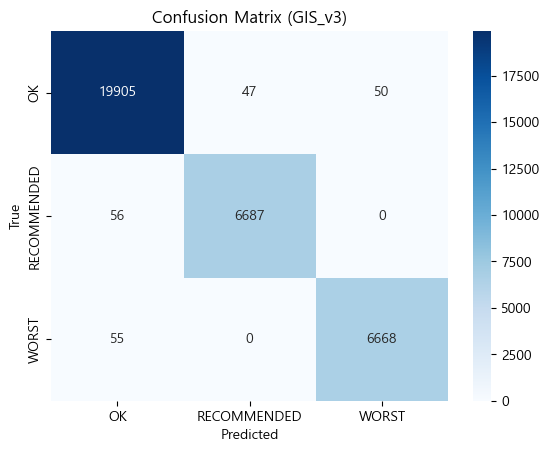

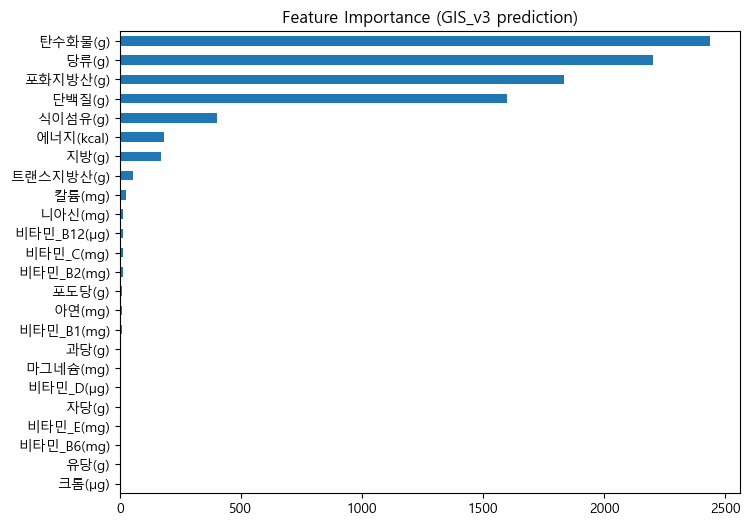

In [21]:
# 1. 데이터 준비
features = [
    '에너지(kcal)','탄수화물(g)','당류(g)','식이섬유(g)','단백질(g)','지방(g)',
    '포화지방산(g)','트랜스지방산(g)','포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

X = df_sub[features]
y = df_sub["GIS_v3_label"]  # v3으로 만든 등급 라벨 사용

# 2. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 모델 학습 (LightGBM)
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. 예측 & 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. 시각화 (혼동행렬)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (GIS_v3)")
plt.show()

# 6. Feature Importance
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (GIS_v3 prediction)")
plt.show()

모델: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5462
[LightGBM] [Info] Number of data points in the train set: 133869, number of used features: 24
[LightGBM] [Info] Start training from score -0.514748
[LightGBM] [Info] Start training from score -1.602099
[LightGBM] [Info] Start training from score -1.605070
Accuracy: 0.9938
              precision    recall  f1-score   support

          OK       0.99      1.00      0.99     20002
 RECOMMENDED       0.99      0.99      0.99      6743
       WORST       0.99      0.99      0.99      6723

    accuracy                           0.99     33468
   macro avg       0.99      0.99      0.99     33468
weighted avg       0.99      0.99      0.99     33468



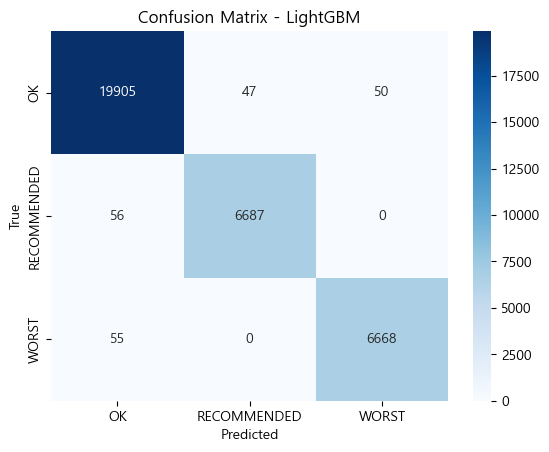

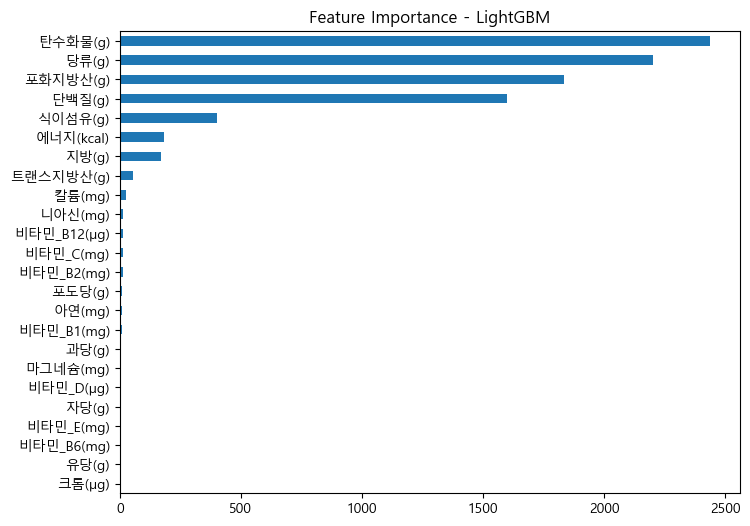

모델: XGBoost
Accuracy: 0.9938
              precision    recall  f1-score   support

          OK       0.99      1.00      0.99     20002
 RECOMMENDED       0.99      0.99      0.99      6743
       WORST       0.99      0.99      0.99      6723

    accuracy                           0.99     33468
   macro avg       0.99      0.99      0.99     33468
weighted avg       0.99      0.99      0.99     33468



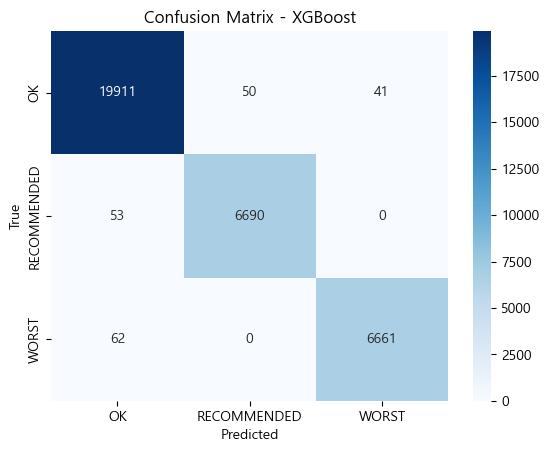

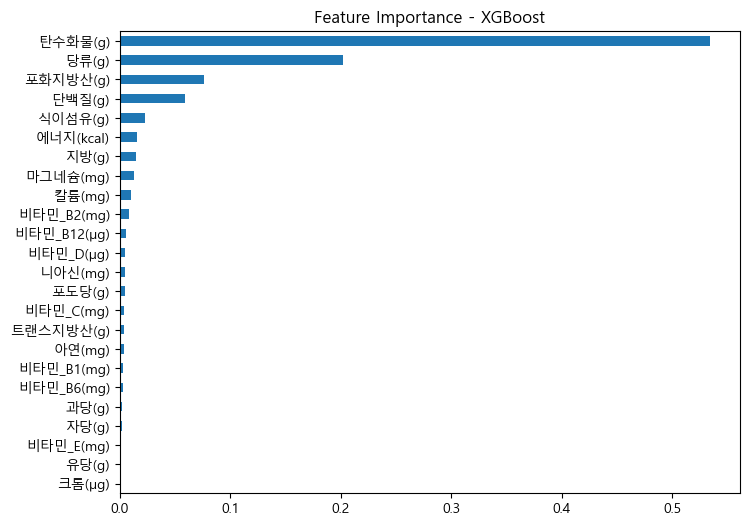

모델: CatBoost
Accuracy: 0.995
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00     20002
 RECOMMENDED       0.99      0.99      0.99      6743
       WORST       1.00      0.99      0.99      6723

    accuracy                           0.99     33468
   macro avg       0.99      0.99      0.99     33468
weighted avg       0.99      0.99      0.99     33468



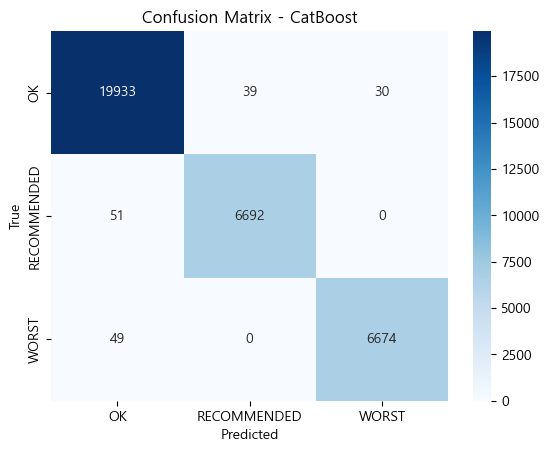

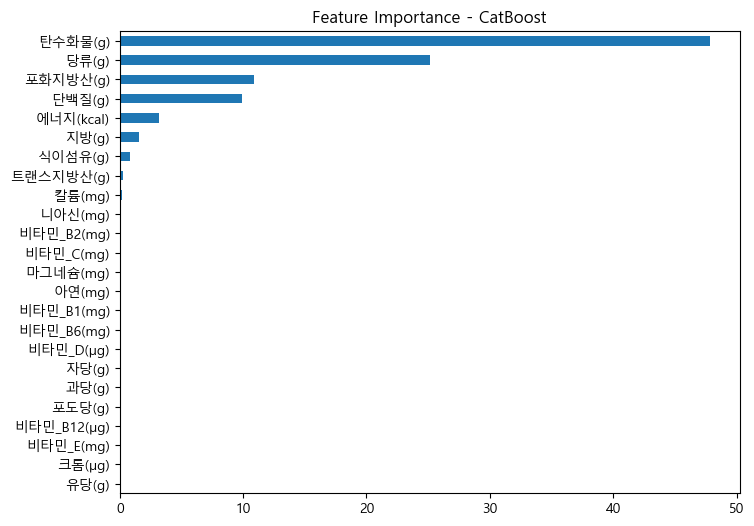

,LightGBM,XGBoost,CatBoost
Accuracy,0.993785,0.993845,0.99495


In [26]:
# 1. 데이터 준비
features = [
    '에너지(kcal)','탄수화물(g)','당류(g)','식이섬유(g)','단백질(g)','지방(g)',
    '포화지방산(g)','트랜스지방산(g)','포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

X = df_sub[features]
y = df_sub["GIS_v3_label"]   # RECOMMENDED / OK / WORST

# 2. XGBoost용 라벨 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. 모델 정의
models = {
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="mlogloss"),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

results = {}

# 4. 학습 및 평가
for name, model in models.items():
    print("="*50)
    print(f"모델: {name}")

    if name == "XGBoost":
        # XGBoost는 숫자 라벨만 허용
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 숫자 라벨 → 문자열 라벨 복원
        y_pred_labels = le.inverse_transform(y_pred)
        y_test_labels = le.inverse_transform(y_test)
        class_labels = le.classes_   # 문자열 라벨

    else:
        # LightGBM, CatBoost는 문자열 라벨 지원
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        model.fit(X_train, y_train)
        y_pred_labels = model.predict(X_test)
        y_test_labels = y_test
        class_labels = model.classes_   # 문자열 라벨

    # 평가 결과 출력
    acc = accuracy_score(y_test_labels, y_pred_labels)
    report = classification_report(y_test_labels, y_pred_labels)
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_labels)

    print("Accuracy:", round(acc, 4))
    print(report)

    # 결과 저장
    results[name] = {"acc": acc, "report": report, "cm": cm, "model": model}

    # 혼동행렬 시각화
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Feature Importance (트리 모델 공통)
    importances = pd.Series(model.feature_importances_, index=features)
    importances.sort_values().plot(kind="barh", figsize=(8,6))
    plt.title(f"Feature Importance - {name}")
    plt.show()


# 5. 모델별 정확도 비교
acc_df = pd.DataFrame({name: [res["acc"]] for name,res in results.items()}, index=["Accuracy"])
display(acc_df)

# ○ 범주를 3개 -> 5개로 변경

In [34]:
features = [
    '에너지(kcal)','탄수화물(g)','당류(g)','식이섬유(g)','단백질(g)','지방(g)',
    '포화지방산(g)','트랜스지방산(g)','포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

df_sub = df.copy()
for c in features:
    if c in df_sub.columns:
        df_sub[c] = pd.to_numeric(df_sub[c], errors="coerce").fillna(0)

# =========================
# 3. GIS v3 계산
# =========================
def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

GIS_raw_v3 = (
    0.5*df_sub['탄수화물(g)'] +
    0.5*df_sub['당류(g)'] -
    0.3*df_sub['식이섬유(g)'] -
    0.2*df_sub['단백질(g)'] +
    0.4*df_sub['포화지방산(g)']
)

df_sub["GIS_v3"] = (minmax(GIS_raw_v3) * 100).round(2)

# =========================
# 4. 5단계 라벨링
# =========================
p20, p40, p60, p80 = np.percentile(df_sub["GIS_v3"], [20, 40, 60, 80])

def label5(v):
    if v <= p20: return "BEST"
    elif v <= p40: return "GOOD"
    elif v <= p60: return "OK"
    elif v <= p80: return "BAD"
    else: return "WORST"

df_sub["GIS_label_5"] = df_sub["GIS_v3"].apply(label5)

# 라벨 인코딩
encoder = LabelEncoder()
df_sub["GIS_label_encoded"] = encoder.fit_transform(df_sub["GIS_label_5"])

print("라벨 매핑:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
display(df_sub[["식품명","GIS_v3","GIS_label_5","GIS_label_encoded"]].head(10))

# =========================
# 5. 학습 데이터 준비
# =========================
X = df_sub[features].fillna(0)
y = df_sub["GIS_label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 6. 모델 학습 & 평가
# =========================
models = {
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="mlogloss"),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

results = []

for name, model in models.items():
    print("="*50)
    print(f"모델: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
    
    results.append([name, round(acc, 4)])

# =========================
# 7. 결과 요약표
# =========================
results_df = pd.DataFrame(results, columns=["Model","Accuracy"])
display(results_df)

# =========================
# 8. 결과 미리보기
# =========================
df_out = df_sub[["식품명","GIS_v3","GIS_label_5"]].head(20)
display(df_out)

라벨 매핑: {'BAD': np.int64(0), 'BEST': np.int64(1), 'GOOD': np.int64(2), 'OK': np.int64(3), 'WORST': np.int64(4)}


,식품명,GIS_v3,GIS_label_5,GIS_label_encoded
0,국밥_돼지머리,11.24,GOOD,2
1,국밥_순대국밥,11.00,GOOD,2
2,국밥_콩나물,11.01,GOOD,2
3,기장밥,12.31,OK,3
4,김밥,11.45,GOOD,2
5,김밥_김치,11.42,GOOD,2
6,김밥_날치알,11.93,OK,3
7,김밥_돈가스,12.09,OK,3
8,김밥_소고기,11.74,OK,3
9,김밥_참치,11.45,GOOD,2


모델: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5473
[LightGBM] [Info] Number of data points in the train set: 133869, number of used features: 24
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Accuracy: 0.9867
              precision    recall  f1-score   support

         BAD       0.98      0.98      0.98      6684
        BEST       0.99      0.99      0.99      6743
        GOOD       0.98      0.98      0.98      6645
          OK       0.98      0.99      0.98      6718
       WORST       0.99      0.99      0.99      6678

    accuracy                           0.99     33468
   macro avg       0.99      0

,Model,Accuracy
0,LightGBM,0.9867
1,XGBoost,0.9874
2,CatBoost,0.9894


,식품명,GIS_v3,GIS_label_5
0,국밥_돼지머리,11.24,GOOD
1,국밥_순대국밥,11.00,GOOD
2,국밥_콩나물,11.01,GOOD
3,기장밥,12.31,OK
4,김밥,11.45,GOOD
5,김밥_김치,11.42,GOOD
6,김밥_날치알,11.93,OK
7,김밥_돈가스,12.09,OK
8,김밥_소고기,11.74,OK
9,김밥_참치,11.45,GOOD


In [36]:
print(df_sub["GIS_label_5"].unique())
print(df_sub["GIS_label_5"].value_counts())

['GOOD' 'OK' 'BAD' 'WORST' 'BEST']
GIS_label_5
BEST     33714
OK       33587
BAD      33418
WORST    33392
GOOD     33226
Name: count, dtype: int64


In [47]:
# 3. GI 범주형 맵핑 (문헌 기반 평균값)
# ========================
# 문헌 평균 GI 값 (대표 범주 예시, 필요시 수정)
gi_mapping = {
    "곡류": 75,      # 쌀밥, 국수 등
    "빵/가공품": 85, # 식빵, 케이크 등
    "과일": 55,
    "채소/콩류": 35,
    "유제품": 45,
    "기타": 50       # 분류 안 되는 것들
}

# 식품군 -> GI 매핑
df["GI"] = df["식품군"].map(gi_mapping).fillna(50)  # 없는 건 50으로 처리

# ========================
# 4. GL 계산
# ========================
df["GL"] = (df["GI"] * df["탄수화물(g)"]) / 100

# ========================
# 5. 5단계 라벨 생성 (퍼센타일 기반)
# ========================
p20, p40, p60, p80 = np.percentile(df["GL"], [20, 40, 60, 80])

def label5(v):
    if v <= p20: return "BEST"
    elif v <= p40: return "GOOD"
    elif v <= p60: return "OK"
    elif v <= p80: return "BAD"
    else: return "WORST"

df["GL_label_5"] = df["GL"].apply(label5)

# ========================
# 6. 라벨 인코딩
# ========================
encoder = LabelEncoder()
df["GL_label_encoded"] = encoder.fit_transform(df["GL_label_5"])

print("라벨 매핑:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# ========================
# 7. 학습 데이터 준비
# ========================
features = [
    '에너지(kcal)','탄수화물(g)','단백질(g)','지방(g)',
    '식이섬유(g)','마그네슘(mg)','아연(mg)','크롬(μg)',
    '포화지방산(g)','트랜스지방산(g)',
    '포도당(g)','자당(g)','과당(g)','유당(g)',
    '칼륨(mg)','비타민_D(μg)','비타민_B1(mg)','비타민_B2(mg)',
    '비타민_B6(mg)','비타민_B12(μg)','니아신(mg)','비타민_C(mg)','비타민_E(mg)'
]

X = df[features].fillna(0)
y = df["GL_label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========================
# 8. 모델 학습 (LightGBM)
# ========================
lgbm = LGBMClassifier(random_state=42, class_weight="balanced")
lgbm.fit(X_train, y_train)

# ========================
# 9. 평가
# ========================
y_pred = lgbm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nAccuracy:", round(acc, 4))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

KeyError: '식품군'